# Environnement


In [2]:
from pgljupyter import *

In [3]:
%%lpy -a True -w 40

Axiom: A
production:
derivation length: 50
A --> [&(60)B][/(180)&(60)B]F /(90) ?P A
B --> F ?P L @O(0.2)B
?P(p) :
     if 4*p.x**2 +4*p.y**2 +(p.z-10)**2 > 100:
            produce L%
     else: produce *
interpretation
L --> [+(90),(2)~l][-(90),(2)~l]

<string>:11: Warning: Colon missing.


LsystemWidget(animate=True, derivationLength=51, is_magic=True, scene={'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5…

/Users/fboudon/Develop/miniconda3/envs/vmango-lab/lib/python3.9/site-packages/pgljupyter/widgets.py:360: Warning: Invalid Color value 2 in setColor (maximum is -1)
  self.__trees.append(self.__lsystem.derive(self.__trees[-1], len(self.__trees), 1))


## Grids

Test the root model : [grid-rootinsoil2.lpy](./env/grid-rootinsoil2.lpy) with [grid.py](./env/grid.py)


In [4]:
import numpy as np
import openalea.plantgl.all  as pgl
import env.grid as mgrid; 
from math import pi, cos, sin

nb_steps = 100
initial_view = 2

maxvalue = 10
xdim = 1
ydim = 5
zdim = 10
grid = mgrid.WaterSoilGrid(origin = (-xdim/2.,-ydim,-zdim), upper = (xdim/2.-0.01,ydim,-0.01), default_value = 1)


#grid.values = np.random.random(grid.size())*maxvalue+1
def sinshape(pos):
  return max(0,1 - abs(sin(pos.z*2*pi/zdim)/1.5 - pos.y/ydim))
  



In [5]:
def getGradient( pos, direction, radius, angle = 180):
    from math import radians
    cid = grid.cellIdFromPoint(pos)
    nbgs = grid.query_voxels_in_cone(pos, direction, radius, radians(angle))
    if len(nbgs) == 0 or ( len(nbgs) == 1 and nbgs[0] == cid): return None
    refval = grid.values[cid]
    totdir = (0,0,0)
    totw = 0
    for nidx in nbgs:
      if nidx != cid:
        lval = grid.values[nidx]
        lpos = grid.getVoxelCenterFromId(nidx)
        totdir = (lpos - pos).normed() * lval + totdir
        totw += lval
    if totw == 0:
      return pgl.Vector3(0,0,0)
    res = totdir / totw
    if res.z > 0 :
      res.z = 0
    else:
      return res


In [7]:
%%lpy -w 10 -a False

dn = 1
dw = 0.05
dt = 0.01

grid.values = np.array([sinshape(grid.getVoxelCenterFromId(i))*maxvalue for i in range(grid.size())])
backward()

pexp = 0.4
initdelay = 3

Axiom: [ @Tp(0,0,-1) @Ts(0.01) @Gc @M(0,0.5,0) +(180) N(0.5,(0,0.5,0),1) A(dn,0) ?P ?H ] G

derivation length: nb_steps
production:

A(dn, o) ?P(v) ?H(h) :
     w = grid.getValueAt(v)
     if  w > 0.5 :
         optdir = getGradient(v,h,3,180 if o == 0 else 30)
         if optdir:
            nv= v+optdir*dn
            nproduce PinpointRel(optdir)
         else:
            nv = v + h*dn           
         if nv in grid : 
           if o == 0 and w > 2:
               nproduce [ +(90) B(initdelay, dn/5.,o+1) ?P ?H ] 
               nproduce /(180) [ +(90) B(initdelay, dn/5.,o+1) ?P ?H ] 
           nproduce N(dn, nv, 1)
           produce A(dn,o) ?P ?H
         else:  produce 
     else: produce 


B(delay, dn,o) ?P(v) ?H(h) :
   if delay > 0:
      produce B(delay-1, dn,o) ?P ?H
   nv = v + h*dn
   if nv in grid : 
     w = grid.getValueAt(v)
     if  w > 0 : produce N(dn, nv, 1) A(dn,o) ?P ?H
     else: produce 
   else: produce



consider: N
N(dnv,p,d) >> x([ N(dnv3,p3,d3)]) N(dnv2,p2,d2):
     w = grid.getValueAt(p)
     if  w > 0 :
       grid.setValueAt(p, max(0,w-dw))
     d = sum(d3,0)+d2+1
     produce N(dnv,p,d)

interpretation:

G :
    global grid
    if sum(grid.values) < 0:
        print(sum(grid.values))
    produce @g(grid.representation())

N(l,o,d) --> _(0.05*pow(d,pexp)) F(l)

A(dn,o) --> [,(4)@O(0.1)]
B(delay, dn,o) --> [,(3)@O(0.1)]
endlsystem

LsystemWidget(animate=True, derivationLength=101, is_magic=True, scene={'data': b'x\xda\x9d\x9a_h\x14G\x1c\xc7…

## Light interaction

Test the light model : [light-growth.lpy](./env/light-growth.lpy) with [light.py](./env/sunDome.py) and [sunDome.py](./env/light.py)

- Analyse the impact of the latitude on the photosynthesis
- Analyse the impact of the plant architecture on the photosynthesis (petiole length, internode length, opening rate of leaves, leaf shape, phyllotaxis, ...)
- Analyze the influence of the plant architecture model on the performance of the plant 
- Analyze the influence of the photosynthetic function (LUE) shade/light plants on the growth
- Analyse the impact of the sun position on the growth
- Analyse the difference between overcast sky and clear sky


In [8]:
import openalea.plantgl.all as pgl
LUE_ = pgl.NurbsCurve2D([(0, 0.281283, 1),(0.175012, 0.66759, 1),(0.385188, 0.964064, 1),
                        (0.652286, 0.93888, 1),(1, 0.950816, 1)]) 
leafshape = pgl.NurbsPatch([[(0.00934393, -0.0549682, 0.00159756, 1), (0.000785378, -0.0342865, 0.00715827, 1), 
                             (-0.00984266, -0.0109794, 0.00955924, 1), (0.000982976, -0.00830777, 0.00660347, 1)], 
                            [(-3.49722e-17, -0.33909, 0.346969, 1), (0.109432, -0.114828, 0.381921, 1), 
                             (0.144924, 0.0976978, 0.372525, 1), (0.0291052, 0.257566, 0.325465, 1)], 
                            [(-0.00959817, -0.434022, 0.726349, 1), (0.11219, -0.124491, 0.724973, 1), 
                             (0.147002, 0.115626, 0.682831, 1), (0.0567277, 0.412544, 0.597588, 1)], 
                            [(0.00430836, -0.234866, 1.05236, 1), (0.0274469, -0.0797845, 1.26865, 1), 
                             (0.0359869, 0.0634305, 1.42421, 1), (0.0520624, 0.31143, 1.0649, 1)]])
nerve = pgl.BezierCurve2D([(-0.5, 0, 1),(-0.166667, 0, 1),(0.166667, 0, 1),(0.5, -0.313636, 1)])
width = pgl.NurbsCurve2D([(0, 0, 1),(0.335622, 0.714318, 1),(0.666667, 0, 1),(1, 0, 1)])
section = pgl.NurbsCurve2D([(-0.5, 0, 1),(-0.166667, -0.140909, 1),(0.171212, -0.136364, 1),(0.5, 0, 1)])
                           
from openalea.lpy.lsysparameters import *
l = LsystemParameters()
l.add_function('LUE', LUE_)
l.add_function('width', width)
l.add_curve('nerve', nerve)
l.add_curve('section', section)
_ = l.add_patch('leafshape', leafshape)


<string>:127: Warning: IndentationWarning: missing indent.
<string>:157: Warning: IndentationWarning: missing indent.


Total Photosynthesis during simulation by all leaves:  118.53608563699687


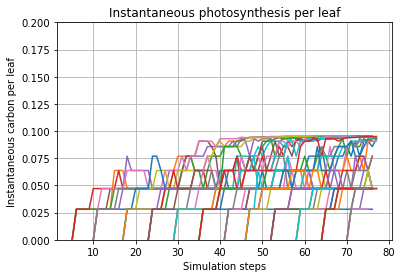

<Figure size 432x288 with 0 Axes>

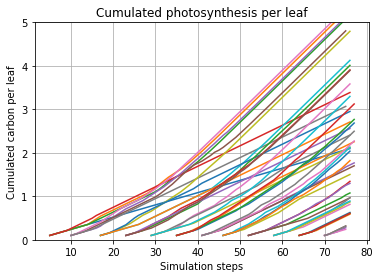

<Figure size 432x288 with 0 Axes>

<string>:127: Warning: IndentationWarning: missing indent.
<string>:157: Warning: IndentationWarning: missing indent.


Total Photosynthesis during simulation by all leaves:  116.39064299168233


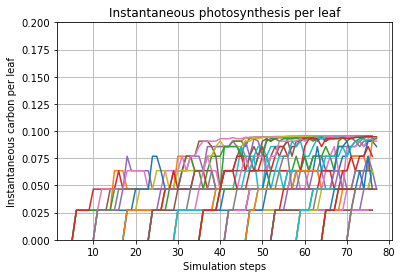

<Figure size 432x288 with 0 Axes>

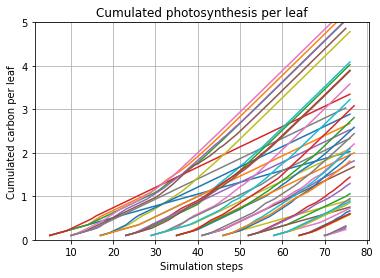

<Figure size 432x288 with 0 Axes>

In [13]:
%%lpy -w 50 -p l
from math import *
from openalea.plantgl.all import *
from env.light import directInterception, directionalInterception, totalInterception,azel2vect
from env.sunDome import getDirectLight, getSkyTurtleSize, getSkyTurtleAt 
import matplotlib.pyplot as plt

extern(elevation = 50)
extern(en_fraction = 50)

SIMTIME = 80  # (80) Total nb of derivations in a simulation

T = 0.5       # (0.5)Plastochron: time for an apex to produce a new organ in a.u. (e.g. 1 week)
TI = 1.       # (1.0)time for internode growth up to maturity


dt = 0.10      # (0.1) time lapse corresponding to a derivation
eps = 0.001    # (0.001) time accuracy limit

# Axis geometry
phy = 45      # (45) phyllo angle (whorl = 360/nb_leaves/2, spiral = 137.5, 99.5, ...)
whorlsize = 4 # (4)  whorl nb: 1 for spiral phyllotaxis
insangle = 35 # (35) insertion angle of leaves (petiole)

#### Plant geometry #### 

# Internodes
endiam = 0.05 # (0.05) in a.u (eg. 1 a.u = 0.1 m)
ENLENMAX = 1. # (1.0) maximum size of an internode
enlen = ENLENMAX * en_fraction/100. # (0.5) internode length is a percentage of a maximal internode length

# Petioles
petioleLength = 0.1 # (0.1)
petioleDiam = 0.01  # (0.01)

# Leaf parameters 
opening_rate = 0.15 # (0.15) controls the rate of leaf additional bending with time
max_added_bend = 50 # (50) in degrees: maximum angle added due to gravity influence and senescence to the leaf insertion angle

# Leaf parameters (for sweep function only)
lengthfactor = 2.     # (2.) in a.u. units 
widthfactor = 3.      # (3.) in a.u. units 
nb_seg = 10        # (10) nb of slices to build a leaf blade
seglen = 1./nb_seg 

#### Irradiance parameters #### 
# Enum definition for selecting the type of scene enlightment
# - FIXEDSUN: fixed sun (direction indicated by sunazel below)
# - MOVINGSUN: sequence of sun positions during a specific day (jj)
# - OVERCAST: overcast sky: light coming from all directions of the sky vault
class LightModelType:   
  FIXEDSUN = 0 
  MOVINGSUN = 1 
  OVERCAST = 2

LightModel = 0

lightresolution = 0.3
#--- case of a fixed sun direction:
# Direction of light, position of the sun
sunazel = (0,60,1)  # (0,60,1) sun (azimuth, elevation, weight). The weight may be used if several orientations are considered during a day. The weights should sum at 1.0
sundirection = azel2vect(sunazel[0],sunazel[1]) # only azimuth and elevation are considered here
sunposition = sundirection * -10 # (-7) place the sun in the scene.

#--- case of a series of sun directions:
latitude = 43.36 # (43.36) Montpellier
longitude = 3.52 # (3.52) Montpellier
julianDay = 222  # (222)

# Range of light value (used for interpolation of colors in leaf)
minlight, maxlight = 1e5, 0

#### Carbon conversion #### 
carbonToShapeCoeff = 0.5   # (0.5) coefficient to convert carbon stored in a leaf to leaf size

def lightcolor(light):
  if abs(maxlight-minlight) < 1e-5 : return 0
  return (light-minlight)/(maxlight-minlight)

#### Useful miscelaneous functions ####

def getlastvalue(list1):
  if len(list1) == 0: return 0.0
  else: return list1[-1] 

# A leaf's state contain 5 parameters:
# - t0: its birth date
# - lifetime: its current lifetime since birth date
# - cumcarbon: a list of floats containing the total amount of carbon photosynthesized by t 
# - light: a list of floats containing the amounts of light received at each time step since the birth of the leaf.
# - carbon: a list of floats containing the instantaneous amount of carbon photosynthesized by the leaf at each dt

module Leaf(t0,lifetime,cumcarbon,light, carbon), LightSource

Axiom: Soil LightSource _(endiam) A(0,T)

derivation length: SIMTIME
production:

# An apex contains two state parameters:
# - t is the absolute time ellapsed since the beginning of the simulation
# - cpt is the plastochrone countdown (in dt steps). It is reset at T after each organ generation
A(t,cpt):
  if cpt < eps : 
    nproduce I(0.001)
    nproduce /(phy) 
    whorlangle = 360 / whorlsize
    for i in range(whorlsize):
      nproduce [ /(whorlangle*i) &(insangle) Petiole(t) Leaf(t,0,[0.1],[0.],[0.0]) ]
    nproduce A(t+dt,T)
  else: produce A(t+dt,cpt-dt)

I(t):
  nproduce I(t+dt)

# This rule evaluates the leaf photosynthesis rate  
# at each step via a user-defined LUE function: delta_carbon/dt = LUE(light)
# This function can be defined either as a python function 
# or as a LPy-function with the name LUE (in a control panel)
Leaf(t0,t,cumcarbon,light,carbon) : 
  currlight = getlastvalue(light)
  currcarbon = getlastvalue(cumcarbon)
  
  delta_c = LUE(min(1,currlight)) * dt  # photosynthesis during dt
  
  cumcarbon.append(currcarbon+delta_c)  # photosynthesis cumulated by the leaf
  carbon.append(delta_c)                # instantaneous photosynthesis on the leaf

  produce Leaf(t0,t+dt,cumcarbon,light,carbon)

Petiole(t): 
  produce Petiole(t+dt)


interpretation:

# Grow an internode as a function of time in both diameter and length
# the growth is limited in time: mature geometry is acheived in time TI
I(t):
  if t <= TI: produce _(endiam*t/TI)F(0.001+enlen*t/TI)
  else: produce _(endiam)F(enlen)

Petiole(t):
  produce _(petioleDiam)F(petioleLength)

# The size of a leaf is proportional to its amount of carbon
#Leaf(t0,t,cumcarbon,light,carbon) : 
#  currlight = getlastvalue(light)
#  currcarbon = getlastvalue(cumcarbon)
#  size = carbonToShapeCoeff*currcarbon 
#  
#

Leaf(t0,t,cumcarbon,light,carbon):
  currlight = getlastvalue(light)
  currcarbon = getlastvalue(cumcarbon)
  size = carbonToShapeCoeff*currcarbon

  nproduce &(max_added_bend*min(1.0,t*opening_rate)) InterpolateColors(5,3,lightcolor(currlight)) 
  # different types of leaves (uncomment one of the following):
  # Nurbs patch:
  nproduce @g(leafshape, size)  
  # Or sweep function:
  # Sweep(nerve,section,lengthfactor*size,seglen,widthfactor*size,width)

Soil:
  nproduce [,(2) @g(Box(1,1,0.01)) ]

# Do not draw to big a light source as it may interact with the lightening of the scene :-)
LightSource : 
  if LightModel == LightModelType.FIXEDSUN:
    nproduce [ ,(1) @R @M(sunposition[0],sunposition[1],sunposition[2]) ,(4) @O(0.1) ]
  elif LightModel == LightModelType.MOVINGSUN:
    sunPos = getDirectLight(latitude, longitude, julianDay, 6, 22)
    for i in range(len(sunPos)):
      #print sunPos[i][0],sunPos[i][1], sunPos[i][2]
      sundir = azel2vect(sunPos[i][0],sunPos[i][1])
      sunpos = sundir * -7
      nproduce [ ,(1) @R @M(sunpos[0],sunpos[1],sunpos[2]) ,(4) @O(0.1) ]
  elif LightModel == LightModelType.OVERCAST:
    # First draw the sky turtle positions 
    sunPos = []
    for i in range(getSkyTurtleSize()):
      sunPos.append( getSkyTurtleAt(i))
    for i in range(len(sunPos)):
      #print sunPos[i][0],sunPos[i][1], sunPos[i][2]
      sundir = azel2vect(sunPos[i][0],sunPos[i][1])
      sunpos = sundir * -7
      nproduce [ ,(1) @R @M(sunpos[0],sunpos[1],sunpos[2]) ,(4) @O(0.05) ]
    # The trajectory of the sun is added
    sunPos2 = getDirectLight(latitude, longitude, julianDay, 6, 22)
    for i in range(len(sunPos2)):
      #print sunPos[i][0],sunPos[i][1], sunPos[i][2]
      sundir2 = azel2vect(sunPos2[i][0],sunPos2[i][1])
      sunpos2 = sundir2 * -7
      nproduce [ ,(1) @R @M(sunpos2[0],sunpos2[1],sunpos2[2]) ,(4) @O(0.1) ]

endlsystem

def StartEach(lstring):
  frameDisplay(True)

# After each growth step (i.e. a derivation and an interpretation step)
# a function is called that determines the light received by each leaf.
# This function can be either:
# - directionalInterception(lscene,[sunazel]) for a fixed sun direction
# - directInterception(lscene, lat, long, jj) for the trajectory of the sun 
#   during a given day
# - totalInterception(lscene, lat, long, jj)  for light coming from the 
#   sky vault (diffuse light)
# In the last two cases, the light is summed-up over all the considered directions 
def EndEach(lstring,lscene):
  global minlight, maxlight
  minlight, maxlight = 1e5, 0

  # computation of light received by leaves (depending on light model)
  if LightModel == LightModelType.FIXEDSUN:
    # directionalInterception(): fractalysis function that computes the light 
    # received the lscene components from one direction only
    res = directionalInterception(lscene,[sunazel],screenresolution=lightresolution) 
  elif LightModel == LightModelType.MOVINGSUN:
    # directInterception(): function that integrates the sunlight over one day (jj)
    # directInterception(scene, lat, long, start=7, stop=19, stp=30, dsun = 1, dGMT = 0)
    # Sum-up light coming from the sun trajectory during a day at a given 
    # latitude and longitude 
    res = directInterception(lscene, latitude, longitude, julianDay, screenresolution=lightresolution)
  elif LightModel == LightModelType.OVERCAST:
    # totalInterception(): function that integrates the sunlight over one day (jj) 
    # over the whole sky vault
    # totalInterception(scene, lat, long, start=7, stop=19, stp=30, dsun = 1, dGMT = 0)
    # Sum-up light coming from the whole sky vault during a day at a given 
    # latitude and longitude 
    res = totalInterception(lscene, latitude, longitude, julianDay,screenresolution=lightresolution)

  for k,v in res.items():
    if lstring[k].name == 'Leaf':
      lstring[k].light.append(v)
      if v < minlight : minlight = v
      if v > maxlight : maxlight = v  
  
  return lstring

def End(lstring, lscene):
  # Total photosynthesis cumulated by the plant:
  totalphot = 0
  for k in range(len(lstring)):
    if lstring[k].name == 'Leaf':
      totalphot += lstring[k].cumcarbon[-1]
  print ("Total Photosynthesis during simulation by all leaves: ", totalphot)

  # plot instantaneous photosynthesis
  plt.figure(1)
  plt.clf()
  t0lists = []
  for k in range(len(lstring)):
    if lstring[k].name == 'Leaf':
      t0 = lstring[k].t0
      lifetime = lstring[k].lifetime
      x = []
      y = []
      lifetimetics = int(lifetime / dt)
      t0tics = int(t0 / dt)
      for t in range(lifetimetics):
        #print "k, t0, lifetime", k, t0tics, lifetimetics #, t0, lifetime
        x.append(t0tics+t)
        #print lstring[k].carbon
        #print k,t
        y.append(lstring[k].carbon[t])
      plt.plot(x,y)
  plt.ylim([0,0.2])
  plt.xlabel('Simulation steps')
  plt.ylabel('Instantaneous carbon per leaf')
  plt.title('Instantaneous photosynthesis per leaf')
  plt.grid()
  plt.show()
  plt.draw()
  
  # plot cumulated photosynthesis
  plt.figure(2)
  plt.clf()
  t0lists = []
  for k in range(len(lstring)):
    if lstring[k].name == 'Leaf':
      t0 = lstring[k].t0
      lifetime = lstring[k].lifetime
      x = []
      y = []
      lifetimetics = int(lifetime / dt)
      t0tics = int(t0 / dt)
      for t in range(lifetimetics):
        #print "k, t0, lifetime", k, t0tics, lifetimetics #, t0, lifetime
        x.append(t0tics+t)
        #print lstring[k].carbon
        #print k,t
        y.append(lstring[k].cumcarbon[t])
      plt.plot(x,y)
  plt.ylim([0,5])
  plt.xlabel('Simulation steps')
  plt.ylabel('Cumulated carbon per leaf')
  plt.title('Cumulated photosynthesis per leaf')
  plt.grid()
  plt.show()
  plt.draw()

## Space Colonization

Completer l'algorithme de colonization de l'espace [spacecolonization-canevas.lpy](./spacecolonization-canevas.lpy)

In [2]:
from openalea.lpy.lsysparameters import *
import openalea.plantgl.all as pgl
l = LsystemParameters()
profile_ = pgl.NurbsCurve2D([(0, 0.0181818, 1),
         (0.219697, 0.0363636, 1),(0.297727, 0.313636, 1),(0.389394, 0.327273, 1),
         (0.593182, 0.290909, 1),(0.688636, 0.0590909, 1),(0.784091, 0.0954545, 1),
         (0.884091, 0.172727, 1),(1, 0, 1)] )

_ = l.add_function('profile', profile_)


In [5]:
%%lpy -w 30 -p l

from openalea.plantgl.all import *
from random import uniform
from math import pi,radians

extern(profile = None)

def generate_points(nbpoints,size):
  pts = []
  for i in range(nbpoints):
    angle = uniform(0,2 * pi)
    ok = False
    while not ok:
      x,y,z =  uniform(-1,1),uniform(-1,1),uniform(0,1)
      if (x**2+y**2) <= profile(z)**2: ok = True
    pts.append(Vector3(x,y,z)*size)
  return pts

pts = generate_points(5000,20)

scale = 1
grow_dist = 1 * scale
killradius = grow_dist * 1.2
perceptionradius = grow_dist * 1.5 
min_nb_pt = 5
rootpos = Vector3(0,0,1)

# place the attractor points into a grid
attractor_grid = Point3Grid(pts, 10)

rootattr = attractor_grid.query_ball_point(rootpos, perceptionradius)
attractor_grid.disable_points(attractor_grid.query_ball_point(rootpos, killradius) )

backward()

initial_radius = 0.04
e = 2.5

def piperadius(ris):
   return pow(sum([pow(ri,e) for ri in ris]),1./e)

module Bud, I, Node, Attractors

Axiom: Attractors @Gc Bud(rootpos, rootattr)

derivation length: 100
production:


Bud(pt, atts) :  
       # compute mean direction    
       # compute new position
       # remove closest attractors
       # produce active nodes    
       pass

Node(pt):
  # find nearest attractor points in cone of perception of given radius and angle
  # if enough attractors are available, produce new bud
  pass

I(pt, r) >> x([I(lpt, lr)]) :
  if len(lr) >= 1:
    produce I(pt,piperadius(lr))

interpretation:

I(pos,radius) --> _(radius) LineTo(pos)
Bud(pt, atts) -->  [SetColor(5) Sphere(0.1*scale)]
Node(pt) -->  [SetColor(3) Sphere(0.1*scale)]

Attractors :
  pttodisplay = attractor_grid.get_enabled_points()
  if len(pttodisplay) > 0:
    nproduce [,(3)
    for p in pttodisplay:
        nproduce @M(p) Sphere(0.05) 
    produce ]
endlsystem